In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans

In [2]:
# Import Data

btc_df = pd.read_csv(
    r"C:\Users\yulig\Desktop\Class Project\Clustering Data\clustered_output\btcusdt_clustered.csv",
    index_col=0,
    parse_dates=True
)

In [3]:
# HMM Regime Classification Creation

hmm_features = [
    'return_1', 'return_5', 'return_20', 'cluster'
]

# Building and Standardizing Dataframe for HMM
X = btc_df[hmm_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# HMM Training and Creation
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=1000)
model.fit(X_scaled)

# HMM Labeling
btc_df.loc[X.index, 'hidden_state'] = model.predict(X_scaled)

# HMM Stats
transition_matrix = pd.DataFrame(model.transmat_)
transition_matrix.columns = [f"To_State_{i}" for i in range(model.n_components)]
transition_matrix.index = [f"From_State_{i}" for i in range(model.n_components)]
print("🔁 Transition Matrix:")
print(transition_matrix)

means_df = pd.DataFrame(model.means_, columns=hmm_features)
means_df.index = [f"Hidden_State_{i}" for i in range(model.n_components)]
print("📊 State Means:")
print(means_df)

🔁 Transition Matrix:
              To_State_0  To_State_1  To_State_2
From_State_0    0.936691    0.025045    0.038264
From_State_1    0.099720    0.839776    0.060504
From_State_2    0.100217    0.038350    0.861433
📊 State Means:
                return_1  return_5  return_20   cluster
Hidden_State_0 -0.027183 -0.062734  -0.094536 -0.725969
Hidden_State_1 -0.466912 -0.972541  -1.320401  1.964495
Hidden_State_2  0.372225  0.791214   1.098567  0.619263


In [4]:
# === Compute average duration of each HMM regime ===

# Drop NaNs just in case
hidden_states = btc_df['hidden_state'].dropna().astype(int).to_numpy()

# Step 1: Mark where the regime changes
regime_changes = np.diff(hidden_states) != 0

# Step 2: Assign regime ID to each block
regime_ids = np.cumsum(np.insert(regime_changes, 0, True))

# Step 3: Create DataFrame to analyze durations
regime_df = pd.DataFrame({
    'regime_id': regime_ids,
    'state': hidden_states
})

# Step 4: Count length of each regime
regime_lengths = regime_df.groupby(['regime_id', 'state']).size().reset_index(name='length')

# Step 5: Average duration per state
avg_durations = regime_lengths.groupby('state')['length'].mean()

print("📊 Average Regime Durations (in candlesticks):")
print(avg_durations)


📊 Average Regime Durations (in candlesticks):
state
0    15.763158
1     6.241259
2     7.216710
Name: length, dtype: float64


In [ ]:
# HMM Visualization

pio.renderers.default = 'browser'

fig = go.Figure()

# Define colors for each state
state_colors = {
    0: 'red',
    1: 'grey',
    2: 'lime'
}

# Drop rows with NaN hidden_state
btc_df_filtered = btc_df.dropna(subset=['hidden_state'])

# Extract arrays
states = btc_df_filtered['hidden_state'].astype(int).to_numpy()
dates = btc_df_filtered.index.to_numpy()
prices = btc_df_filtered['close'].to_numpy()

# Initialize segment
prev_state = states[0]
segment_dates = [dates[0]]
segment_prices = [prices[0]]

for i in range(1, len(states)):
    if states[i] == prev_state:
        segment_dates.append(dates[i])
        segment_prices.append(prices[i])
    else:
        # Plot the current segment
        fig.add_trace(go.Scatter(
            x=segment_dates,
            y=segment_prices,
            mode='lines',
            line=dict(color=state_colors[prev_state], width=2),
            name=f"State {int(prev_state)}",
            showlegend=False
        ))
        # Start new segment
        prev_state = states[i]
        segment_dates = [dates[i]]
        segment_prices = [prices[i]]
        
# Plot the last segment
fig.add_trace(go.Scatter(
    x=segment_dates,
    y=segment_prices,
    mode='lines',
    line=dict(color=state_colors[prev_state], width=2),
    name=f"State {int(prev_state)}",
    showlegend=False
))

# Add legend entries (clean version)
for state, color in state_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='lines',
        line=dict(color=color, width=2),
        name=f"State {state}"
    ))

# Final layout
fig.update_layout(
    title='BTC Price with Regimes Colored by HMM State',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

fig.show()


In [11]:
# Synthetic Data For Trading Strat Creation

pio.renderers.default = 'browser'

# --- LOAD REAL RETURN STATS ---
real_returns = btc_df['return_1'].dropna()
mu = real_returns.mean()
sigma = real_returns.std()

# --- CONFIG ---
n_days = 1825
initial_price = 104662.05

# --- SAMPLE RETURNS FROM NORMAL DIST ---
synthetic_returns = np.random.normal(loc=mu, scale=sigma, size=n_days)

# --- BUILD PRICE SERIES ---
synthetic_prices = [initial_price]
for r in synthetic_returns:
    new_price = synthetic_prices[-1] * np.exp(r)
    synthetic_prices.append(new_price)
synthetic_prices = synthetic_prices[1:]

# --- BUILD DATAFRAME ---
sim_df = pd.DataFrame({
    'timestamp': pd.date_range(start='2025-01-01', periods=n_days, freq='D'),
    'log_return': synthetic_returns,
    'price': synthetic_prices
})

# --- COMPUTE ROLLING RETURNS ---
sim_df['return_1'] = np.log(sim_df['price'] / sim_df['price'].shift(1))
sim_df['return_5'] = np.log(sim_df['price'] / sim_df['price'].shift(5))
sim_df['return_20'] = np.log(sim_df['price'] / sim_df['price'].shift(20))

# --- COMPUTE RSI ---
rsi_window = 14
delta = sim_df['price'].diff()

gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(window=rsi_window).mean()
avg_loss = loss.rolling(window=rsi_window).mean()

rs = avg_gain / avg_loss
sim_df['rsi'] = 100 - (100 / (1 + rs))

# --- COMPUTE BOLLINGER BAND WIDTH ---
bb_window = 20
bb_std = 2

rolling_mean = sim_df['price'].rolling(window=bb_window).mean()
rolling_std = sim_df['price'].rolling(window=bb_window).std()

bb_upper = rolling_mean + bb_std * rolling_std
bb_lower = rolling_mean - bb_std * rolling_std

sim_df['bb_width'] = (bb_upper - bb_lower) / rolling_mean

# --- COMPUTE VOLATILITY INDICATORS ---
sim_df['vol_short'] = sim_df['return_1'].rolling(window=7).std()
sim_df['vol_medium'] = sim_df['return_1'].rolling(window=42).std()
sim_df['vol_long'] = sim_df['return_1'].rolling(window=126).std()

# --- COMPUTE MACD HISTOGRAM ---
ema_fast = sim_df['price'].ewm(span=12, adjust=False).mean()
ema_slow = sim_df['price'].ewm(span=26, adjust=False).mean()
macd_line = ema_fast - ema_slow
signal_line = macd_line.ewm(span=50, adjust=False).mean()

sim_df['histogram'] = macd_line - signal_line

# --- SELECT CLUSTERING FEATURES ---
clustering_features = [
    'return_1', 'return_5', 'return_20',
    'rsi', 'bb_width',
    'vol_short', 'vol_medium', 'vol_long',
    'histogram'
]

# --- DROP NaNs ---
X_cluster = sim_df[clustering_features].dropna()

# --- SCALE DATA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# --- FIT PRIMARY KMEANS ON SYNTHETIC (OR LOAD EXISTING ONE FROM REAL DATA) ---
primary_kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
sim_df.loc[X_cluster.index, 'cluster'] = primary_kmeans.fit_predict(X_scaled)



# --- SAVE TO CSV ---
sim_df.to_csv("synthetic_from_real_returns.csv", index=False)

# --- PLOT ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=sim_df['timestamp'],
    y=sim_df['price'],
    mode='lines',
    line=dict(color='cyan', width=2),
    name='Synthetic Price'
))

fig.update_layout(
    title='📈 Synthetic BTC Price (from Real Return_1 Distribution)',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

fig.show()

In [12]:
# === Build Regime Classifier from HMM Centroids ===
regime_features = ['return_1', 'return_5', 'return_20', 'cluster']

# Load the HMM regime centroids (already standardized)
regime_centroids = model.means_

# Create labeled DataFrame for centroid reference
hmm_centroids_df = pd.DataFrame(
    regime_centroids,
    columns=regime_features,
    index=[f"Hidden_State_{i}" for i in range(regime_centroids.shape[0])]
)

print("📌 HMM Regime Centroids (standardized feature space):")
print(hmm_centroids_df)

# Classify points based on nearest centroid
def classify_point_by_centroid(row, centroids_df, feature_cols):
    point = row[feature_cols].values.astype(float)
    distances = centroids_df[feature_cols].apply(lambda c: np.linalg.norm(point - c.values), axis=1)
    return distances.idxmin()

# Apply classification to synthetic data
classified_regimes = [np.nan] * 128  # burn-in
for i in range(128, len(sim_df)):
    row = sim_df.iloc[i]
    regime = classify_point_by_centroid(row, hmm_centroids_df, regime_features)
    classified_regimes.append(regime)

sim_df['classified_regime'] = classified_regimes

# --- Classify Bullish/Bearish/Neutral Based on Avg Return ---
hmm_centroids_df['avg_return'] = hmm_centroids_df[['return_1', 'return_5', 'return_20']].mean(axis=1)
sorted_centroids = hmm_centroids_df.sort_values('avg_return', ascending=False)

bullish_state = sorted_centroids.index[0]
bearish_state = sorted_centroids.index[-1]

# Assign labels
regime_label_map = {
    bullish_state: 'bullish',
    bearish_state: 'bearish'
}
# Neutral fallback
for label in hmm_centroids_df.index:
    if label not in regime_label_map:
        regime_label_map[label] = 'neutral'

# Map label column
sim_df['classified_regime_label'] = sim_df['classified_regime'].map(regime_label_map)

# --- Optional: Save result ---
sim_df.to_csv("sim_df_with_classified_regimes.csv", index=False)

print(f"✅ Bullish State: {bullish_state}, Bearish State: {bearish_state}")


📌 HMM Regime Centroids (standardized feature space):
                return_1  return_5  return_20   cluster
Hidden_State_0 -0.027183 -0.062734  -0.094536 -0.725969
Hidden_State_1 -0.466912 -0.972541  -1.320401  1.964495
Hidden_State_2  0.372225  0.791214   1.098567  0.619263
✅ Bullish State: Hidden_State_2, Bearish State: Hidden_State_1


In [13]:
# === Build Regime Classifier from HMM Centroids ===
regime_features = ['return_1', 'return_5', 'return_20', 'cluster']

# Load the HMM regime centroids (already standardized)
regime_centroids = model.means_

# Create labeled DataFrame for centroid reference
hmm_centroids_df = pd.DataFrame(
    regime_centroids,
    columns=regime_features,
    index=[f"Hidden_State_{i}" for i in range(regime_centroids.shape[0])]
)

print("📌 HMM Regime Centroids (standardized feature space):")
print(hmm_centroids_df)

# --- Classify Points by Nearest Centroid ---
def classify_point_by_centroid(row, centroids_df, feature_cols):
    point = row[feature_cols].values.astype(float)
    distances = centroids_df[feature_cols].apply(lambda c: np.linalg.norm(point - c.values), axis=1)
    return distances.idxmin()

# Apply classification to synthetic data
classified_regimes = [np.nan] * 128  # burn-in
for i in range(128, len(sim_df)):
    row = sim_df.iloc[i]
    regime_idx = classify_point_by_centroid(row, hmm_centroids_df, regime_features)
    classified_regimes.append(f"Hidden_State_{regime_idx}")  # <-- convert to string label here!

sim_df['classified_regime'] = classified_regimes

# --- Classify Bullish/Bearish/Neutral Based on Avg Return ---
hmm_centroids_df['avg_return'] = hmm_centroids_df[['return_1', 'return_5', 'return_20']].mean(axis=1)
sorted_centroids = hmm_centroids_df.sort_values('avg_return', ascending=False)

bullish_state = sorted_centroids.index[0]
bearish_state = sorted_centroids.index[-1]

# Assign labels
regime_label_map = {
    bullish_state: 'bullish',
    bearish_state: 'bearish'
}
# Neutral fallback
for label in hmm_centroids_df.index:
    if label not in regime_label_map:
        regime_label_map[label] = 'neutral'

# Map final label column
sim_df['classified_regime_label'] = sim_df['classified_regime'].map(regime_label_map)

# Optional: Save to CSV
sim_df.to_csv("sim_df_with_classified_regimes.csv", index=False)

# --- Clean and remap incorrect regime labels ---

# Extract correct state name (e.g., 'Hidden_State_2')
sim_df['classified_regime'] = sim_df['classified_regime'].str.extract(r'(Hidden_State_\d)').squeeze()

# Manual mapping (you confirmed these)
state_to_label = {
    'Hidden_State_2': 'bullish',
    'Hidden_State_0': 'bearish',
    'Hidden_State_1': 'neutral'  # optional; you can omit if not used
}

# Apply final labels
sim_df['classified_regime_label'] = sim_df['classified_regime'].map(state_to_label)


📌 HMM Regime Centroids (standardized feature space):
                return_1  return_5  return_20   cluster
Hidden_State_0 -0.027183 -0.062734  -0.094536 -0.725969
Hidden_State_1 -0.466912 -0.972541  -1.320401  1.964495
Hidden_State_2  0.372225  0.791214   1.098567  0.619263


In [87]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'browser'

fig = go.Figure()

# Extract the unique labels used (likely just 'bullish' and 'bearish')
used_labels = sim_df['classified_regime_label'].dropna().unique()

# Define universal color palette
label_palette = {
    'bullish': 'lime',
    'bearish': 'red',
    'neutral': 'grey'  # Will be excluded if unused
}

# Build the active color map (only used labels)
label_colors = {label: label_palette[label] for label in used_labels if label in label_palette}

# Drop NaNs
df = sim_df.dropna(subset=['classified_regime_label']).copy()

# Extract arrays
dates = df['timestamp'].to_numpy()
prices = df['price'].to_numpy()
labels = df['classified_regime_label'].to_numpy()

# Initialize first segment
prev_label = labels[0]
segment_dates = [dates[0]]
segment_prices = [prices[0]]

# Segment loop
for i in range(1, len(df)):
    if labels[i] == prev_label:
        segment_dates.append(dates[i])
        segment_prices.append(prices[i])
    else:
        fig.add_trace(go.Scatter(
            x=segment_dates,
            y=segment_prices,
            mode='lines',
            line=dict(color=label_colors[prev_label], width=2),
            name=prev_label,
            showlegend=False
        ))
        # Start new segment
        prev_label = labels[i]
        segment_dates = [dates[i]]
        segment_prices = [prices[i]]

# Last segment
fig.add_trace(go.Scatter(
    x=segment_dates,
    y=segment_prices,
    mode='lines',
    line=dict(color=label_colors[prev_label], width=2),
    name=prev_label,
    showlegend=False
))

# Add legend (only for used labels)
for label, color in label_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='lines',
        line=dict(color=color, width=2),
        name=label.capitalize()
    ))

# Layout
fig.update_layout(
    title='📊 Synthetic Price Colored by HMM Regime (Bullish/Bearish Only)',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

fig.show()


C:\Users\yulig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



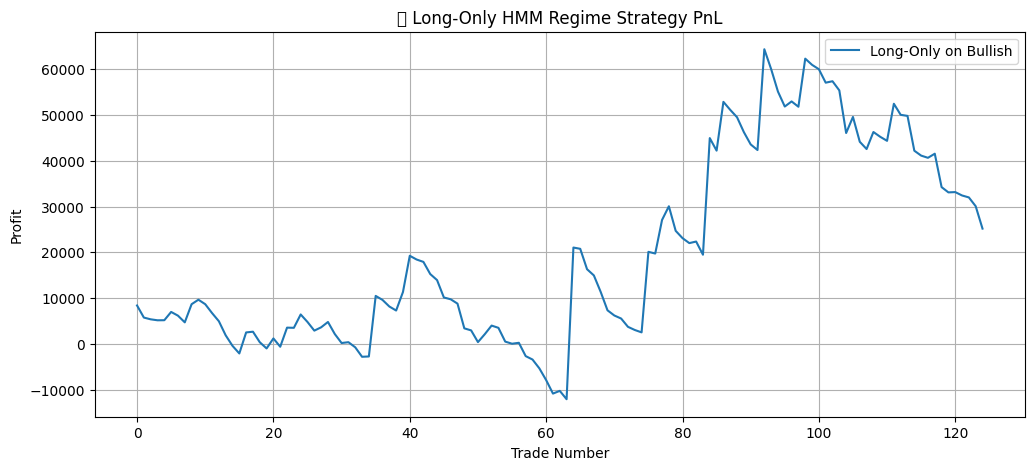

In [ ]:
position = 0  # 1 for long, 0 for cash
entry_price = None
returns = []

for i in range(1, len(sim_df)):
    current_label = sim_df.loc[i, 'classified_regime_label']
    price_now = sim_df.loc[i, 'price']

    if current_label == 'bullish':
        if position == 0:
            # Enter long
            position = 1
            entry_price = price_now
    else:
        if position == 1:
            # Exit long
            returns.append(price_now - entry_price)
            position = 0
            entry_price = None

# Close final long
if position == 1:
    returns.append(sim_df.iloc[-1]['price'] - entry_price)

# Plot
cumulative_return = np.cumsum(returns)
plt.figure(figsize=(12, 5))
plt.plot(cumulative_return, label='Long-Only on Bullish')
plt.title("📈 Long-Only HMM Regime Strategy PnL")
plt.xlabel("Trade Number")
plt.ylabel("Profit")
plt.grid(True)
plt.legend()
plt.show()


In [15]:
def generate_synthetic_market(mu: float, sigma: float, n_days: int = 1825,
                               initial_price: float = 100_000, plot: bool = False) -> pd.DataFrame:
    # --- SAMPLE RETURNS FROM NORMAL DIST ---
    synthetic_returns = np.random.normal(loc=mu, scale=sigma, size=n_days)

    # --- BUILD PRICE SERIES ---
    synthetic_prices = [initial_price]
    for r in synthetic_returns:
        new_price = synthetic_prices[-1] * np.exp(r)
        synthetic_prices.append(new_price)
    synthetic_prices = synthetic_prices[1:]

    # --- BUILD DATAFRAME ---
    sim_df = pd.DataFrame({
        'timestamp': pd.date_range(start='2025-01-01', periods=n_days, freq='D'),
        'log_return': synthetic_returns,
        'price': synthetic_prices
    })

    # --- COMPUTE ROLLING RETURNS ---
    sim_df['return_1'] = np.log(sim_df['price'] / sim_df['price'].shift(1))
    sim_df['return_5'] = np.log(sim_df['price'] / sim_df['price'].shift(5))
    sim_df['return_20'] = np.log(sim_df['price'] / sim_df['price'].shift(20))

    # --- COMPUTE RSI ---
    rsi_window = 14
    delta = sim_df['price'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=rsi_window).mean()
    avg_loss = loss.rolling(window=rsi_window).mean()
    rs = avg_gain / avg_loss
    sim_df['rsi'] = 100 - (100 / (1 + rs))

    # --- BOLLINGER BAND WIDTH ---
    bb_window = 20
    bb_std = 2
    rolling_mean = sim_df['price'].rolling(window=bb_window).mean()
    rolling_std = sim_df['price'].rolling(window=bb_window).std()
    bb_upper = rolling_mean + bb_std * rolling_std
    bb_lower = rolling_mean - bb_std * rolling_std
    sim_df['bb_width'] = (bb_upper - bb_lower) / rolling_mean

    # --- VOLATILITY ---
    sim_df['vol_short'] = sim_df['return_1'].rolling(window=7).std()
    sim_df['vol_medium'] = sim_df['return_1'].rolling(window=42).std()
    sim_df['vol_long'] = sim_df['return_1'].rolling(window=126).std()

    # --- MACD HISTOGRAM ---
    ema_fast = sim_df['price'].ewm(span=12, adjust=False).mean()
    ema_slow = sim_df['price'].ewm(span=26, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=50, adjust=False).mean()
    sim_df['histogram'] = macd_line - signal_line

    # --- CLUSTERING ---
    clustering_features = [
        'return_1', 'return_5', 'return_20',
        'rsi', 'bb_width',
        'vol_short', 'vol_medium', 'vol_long',
        'histogram'
    ]
    X_cluster = sim_df[clustering_features].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    primary_kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    sim_df.loc[X_cluster.index, 'cluster'] = primary_kmeans.fit_predict(X_scaled)

    # --- OPTIONAL: PLOT ---
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=sim_df['timestamp'],
            y=sim_df['price'],
            mode='lines',
            line=dict(color='cyan', width=2),
            name='Synthetic Price'
        ))
        fig.update_layout(
            title='📈 Synthetic BTC Price (from Real Return_1 Distribution)',
            xaxis_title='Date',
            yaxis_title='Price',
            template='plotly_dark',
            plot_bgcolor='black',
            paper_bgcolor='black',
            font=dict(color='white')
        )
        fig.show()

    return sim_df

In [16]:
def classify_regimes(sim_df, regime_centroids, regime_features):
    """
    Classify each row in sim_df into HMM regime and label it as bullish/bearish/neutral,
    based on the actual average return_1 after classification.
    """
    # Wrap centroids in DataFrame
    if isinstance(regime_centroids, np.ndarray):
        hmm_centroids_df = pd.DataFrame(
            regime_centroids,
            columns=regime_features,
            index=[f"Hidden_State_{i}" for i in range(regime_centroids.shape[0])]
        )
    else:
        hmm_centroids_df = regime_centroids.copy()

    # --- Classify Points by Nearest Centroid ---
    def classify_point_by_centroid(row, centroids_df, feature_cols):
        point = row[feature_cols].values.astype(float)
        distances = centroids_df[feature_cols].apply(lambda c: np.linalg.norm(point - c.values), axis=1)
        return distances.idxmin()

    classified_regimes = [np.nan] * 128  # burn-in
    for i in range(128, len(sim_df)):
        row = sim_df.iloc[i]
        regime_idx = classify_point_by_centroid(row, hmm_centroids_df, regime_features)
        classified_regimes.append(regime_idx)

    sim_df['classified_regime'] = classified_regimes

    # ✅ NOW LABEL BASED ON ACTUAL RETURN IN THE DATA
    return_means = sim_df.groupby('classified_regime')['return_1'].mean().sort_values(ascending=False)

    # Highest return_1 gets 'bullish', lowest gets 'bearish'
    bullish_state = return_means.index[0]
    bearish_state = return_means.index[-1]

    regime_label_map = {}
    for state in sim_df['classified_regime'].unique():
        if state == bullish_state:
            regime_label_map[state] = 'bullish'
        elif state == bearish_state:
            regime_label_map[state] = 'bearish'
        else:
            regime_label_map[state] = 'neutral'

    sim_df['classified_regime'] = sim_df['classified_regime'].astype(str)
    sim_df['classified_regime_label'] = sim_df['classified_regime'].map(regime_label_map)

    return sim_df, hmm_centroids_df, bullish_state, bearish_state


In [17]:
# Group by classified regime label and compute summary stats
summary = sim_df.groupby('classified_regime_label').agg({
    'return_1': ['mean', 'std'],
    'return_5': ['mean', 'std'],
    'return_20': ['mean', 'std'],
    'price': ['mean', 'std', 'count']
})

# Flatten multi-level columns
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()

# Display the summary
import pprint
print("\n📊 Regime-wise Summary Statistics:")
pprint.pprint(summary)



📊 Regime-wise Summary Statistics:
  classified_regime_label  return_1_mean  return_1_std  return_5_mean  \
0                 bearish      -0.004159      0.011991      -0.017600   
1                 bullish       0.003832      0.013332       0.015583   

   return_5_std  return_20_mean  return_20_std    price_mean     price_std  \
0      0.024278       -0.050737       0.039436  73068.928770  20659.267375   
1      0.026569        0.039106       0.042908  75578.278735  21644.100789   

   price_count  
0          907  
1          790  


In [72]:
mu = btc_df['return_1'].dropna().mean()
sigma = btc_df['return_1'].dropna().std()

sim_df = generate_synthetic_market(mu, sigma, n_days=1825, initial_price=104662.05, plot=True)


In [73]:
# HMM model must be trained earlier (on real BTC data)
# For example:
# from hmmlearn.hmm import GaussianHMM
# hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000).fit(X_train)

# Once you have your trained HMM:
regime_features = ['return_1', 'return_5', 'return_20', 'cluster']

# Run classification
sim_df, hmm_centroids_df, bull_state, bear_state = classify_regimes(
    sim_df,
    model.means_,
    regime_features
)


In [86]:
import plotly.graph_objects as go

def plot_classified_regimes(sim_df):
    # Treat 'neutral' as 'bearish' in label for plotting
    df = sim_df.copy()
    df['plot_label'] = df['classified_regime_label'].replace({'neutral': 'bearish'})

    # Identify consecutive blocks of same regime
    df['regime_block'] = (df['plot_label'] != df['plot_label'].shift()).cumsum()

    # Prepare plot
    fig = go.Figure()

    for _, segment in df.groupby('regime_block'):
        regime_label = segment['plot_label'].iloc[0]

        fig.add_trace(go.Scatter(
            x=segment['timestamp'],
            y=segment['price'],
            mode='lines',
            name=regime_label,
            line=dict(
                color='green' if regime_label == 'bullish' else 'red',
                width=2
            ),
            showlegend=True  # Will de-dupe later
        ))

    # De-duplicate legend by keeping only one entry per label
    fig.for_each_trace(lambda t: t.update(showlegend=False))
    seen = set()
    for trace in fig.data:
        if trace.name not in seen:
            trace.showlegend = True
            seen.add(trace.name)

    fig.update_layout(
        title='📊 Regime-Classified Synthetic Market',
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_dark',
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white')
    )

    fig.show()
plot_classified_regimes(sim_df)

In [42]:
def simulate_and_plot_trading_strategy(sim_df):
    """
    Runs strategy on sim_df, plots buy/sell points, prints PnL and Sharpe,
    and includes Buy-and-Hold benchmark for comparison.
    """
    df = sim_df.dropna(subset=['classified_regime_label', 'price']).copy().reset_index(drop=True)

    position = 0
    entry_price = None
    entry_idx = None
    trade_returns = []
    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        label = df.loc[i, 'classified_regime_label']
        price = df.loc[i, 'price']

        if label == 'bullish':
            if position == 0:
                position = 1
                entry_price = price
                entry_idx = i
                buy_signals.append((i, price))
        else:
            if position == 1:
                position = 0
                pnl_pct = (price / entry_price) - 1
                trade_returns.append(pnl_pct)
                sell_signals.append((i, price))
                entry_price = None
                entry_idx = None

    if position == 1:
        final_price = df.iloc[-1]['price']
        pnl_pct = (final_price / entry_price) - 1
        trade_returns.append(pnl_pct)
        sell_signals.append((len(df)-1, final_price))

    # Strategy performance
    cumulative_pnl = np.prod([1 + r for r in trade_returns]) - 1 if trade_returns else 0
    sharpe = (np.mean(trade_returns) / np.std(trade_returns) * np.sqrt(252)) if len(trade_returns) > 1 and np.std(trade_returns) > 0 else 0

    # Buy-and-hold performance
    buy_price = df['price'].iloc[0]
    sell_price = df['price'].iloc[-1]
    bh_return = (sell_price / buy_price) - 1

    daily_returns = df['price'].pct_change().dropna()
    bh_sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0

    # Print metrics
    print("\n🚀 Strategy Performance:")
    print(f"Total PnL: {cumulative_pnl * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Number of Trades: {len(trade_returns)}")
    print(f"Average Trade Return: {np.mean(trade_returns) * 100:.2f}%" if trade_returns else "N/A")

    print("\n📈 Buy-and-Hold Benchmark:")
    print(f"Total PnL: {bh_return * 100:.2f}%")
    print(f"Sharpe Ratio: {bh_sharpe:.2f}")

    # Plot chart
    plt.figure(figsize=(14, 6))
    plt.plot(df['price'].values, label='Price', color='black', linewidth=1)

    if buy_signals:
        buy_x, buy_y = zip(*buy_signals)
        plt.scatter(buy_x, buy_y, marker='^', color='green', label='Buy', s=60)

    if sell_signals:
        sell_x, sell_y = zip(*sell_signals)
        plt.scatter(sell_x, sell_y, marker='v', color='red', label='Sell', s=60)

    plt.title("📊 Strategy: Buy/Sell vs. Price")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'strategy_pnl': cumulative_pnl,
        'strategy_sharpe': sharpe,
        'buy_and_hold_pnl': bh_return,
        'buy_and_hold_sharpe': bh_sharpe,
        'returns': trade_returns
    }


In [66]:
def simulate_and_plot_trading_strategy(sim_df):
    """
    Runs strategy on sim_df, prints PnL and Sharpe,
    includes Buy-and-Hold benchmark for comparison,
    and shows Plotly graph with turquoise highlights for in-position trades.
    """
    df = sim_df.dropna(subset=['classified_regime_label', 'price']).copy().reset_index(drop=True)

    position = 0
    entry_price = None
    entry_idx = None
    trade_returns = []
    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        label = df.loc[i, 'classified_regime_label']
        price = df.loc[i, 'price']

        if label == 'bullish':
            if position == 0:
                position = 1
                entry_price = price
                entry_idx = i
                buy_signals.append((i, price))
        else:
            if position == 1:
                pnl_pct = (price / entry_price) - 1
                trade_returns.append(pnl_pct)
                sell_signals.append((i, price))
                position = 0
                entry_price = None
                entry_idx = None

    if position == 1:
        final_price = df.iloc[-1]['price']
        pnl_pct = (final_price / entry_price) - 1
        trade_returns.append(pnl_pct)
        sell_signals.append((len(df) - 1, final_price))

    # Strategy performance
    cumulative_pnl = np.prod([1 + r for r in trade_returns]) - 1 if trade_returns else 0
    sharpe = (np.mean(trade_returns) / np.std(trade_returns) * np.sqrt(252)) if len(trade_returns) > 1 and np.std(trade_returns) > 0 else 0

    # Buy-and-hold performance
    buy_price = df['price'].iloc[0]
    sell_price = df['price'].iloc[-1]
    bh_return = (sell_price / buy_price) - 1

    daily_returns = df['price'].pct_change().dropna()
    bh_sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0

    # Print metrics
    print("\n🚀 Strategy Performance:")
    print(f"Total PnL: {cumulative_pnl * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Number of Trades: {len(trade_returns)}")
    print(f"Average Trade Return: {np.mean(trade_returns) * 100:.2f}%" if trade_returns else "N/A")

    print("\n📈 Buy-and-Hold Benchmark:")
    print(f"Total PnL: {bh_return * 100:.2f}%")
    print(f"Sharpe Ratio: {bh_sharpe:.2f}")

    # Plotly plot
    price_trace = go.Scatter(
        x=df.index,
        y=df['price'],
        mode='lines',
        name='Price',
        line=dict(color='gray', width=1),
        hoverinfo='x+y'
    )

    highlight_segments = []
    in_position = False
    start_idx = None

    for i in range(1, len(df)):
        label = df.loc[i, 'classified_regime_label']
        if label == 'bullish' and not in_position:
            start_idx = i
            in_position = True
        elif label != 'bullish' and in_position:
            end_idx = i
            segment = go.Scatter(
                x=df.index[start_idx:end_idx + 1],
                y=df['price'].iloc[start_idx:end_idx + 1],
                mode='lines',
                name='In Position',
                line=dict(color='lime', width=3),
                showlegend=(len(highlight_segments) == 0)
            )
            highlight_segments.append(segment)
            in_position = False

    if in_position:
        segment = go.Scatter(
            x=df.index[start_idx:],
            y=df['price'].iloc[start_idx:],
            mode='lines',
            name='In Position',
            line=dict(color='turquoise', width=3),
            showlegend=(len(highlight_segments) == 0)
        )
        highlight_segments.append(segment)

    fig = go.Figure([price_trace] + highlight_segments)

    fig.update_layout(
        title="📊 Strategy Execution: Highlighting Bullish Trades",
        xaxis_title="Time Step",
        yaxis_title="Price",
        legend=dict(x=0.01, y=0.99),
        template='plotly_dark',
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        autosize=True,
        margin=dict(l=0, r=0, t=50, b=0),
        height=None
)


    fig.show()

    return {
        'strategy_pnl': cumulative_pnl,
        'strategy_sharpe': sharpe,
        'buy_and_hold_pnl': bh_return,
        'buy_and_hold_sharpe': bh_sharpe,
        'returns': trade_returns
    }


In [74]:
results = simulate_and_plot_trading_strategy(sim_df)
results


🚀 Strategy Performance:
Total PnL: 28.69%
Sharpe Ratio: 1.04
Number of Trades: 117
Average Trade Return: 0.32%

📈 Buy-and-Hold Benchmark:
Total PnL: 17.77%
Sharpe Ratio: 0.22


{'strategy_pnl': np.float64(0.28685098713495627),
 'strategy_sharpe': np.float64(1.0420148141686552),
 'buy_and_hold_pnl': np.float64(0.17768128504380765),
 'buy_and_hold_sharpe': np.float64(0.22043934699420026),
 'returns': [np.float64(-0.004433692886218088),
  np.float64(-0.009361439833006302),
  np.float64(0.005494510425782639),
  np.float64(-0.011681249167358021),
  np.float64(-0.008237264484689644),
  np.float64(-0.03399353858862608),
  np.float64(-0.024404738862628728),
  np.float64(-0.0190995324349299),
  np.float64(-0.011518229728299523),
  np.float64(-0.01420524167548709),
  np.float64(-0.0004417215540682973),
  np.float64(-0.016031394967282675),
  np.float64(0.012631885590510317),
  np.float64(-0.0049445012723156045),
  np.float64(-0.0073774259401455655),
  np.float64(0.010702163557328781),
  np.float64(-0.016337646885205337),
  np.float64(-0.00033520002312781294),
  np.float64(0.11320350851738237),
  np.float64(-0.010872370040588053),
  np.float64(-0.017394497470580417),
  n

In [77]:
# Simulation and Monte Carlo

def backtest_regime_strategy(sim_df, bullish_label='bullish', bearish_label='neutral'):
    """
    Simulates a simple trading strategy: enter long on bullish, exit on non-bullish.
    Calculates total %PnL and Sharpe ratio based on trade returns.
    """
    df = sim_df.dropna(subset=['classified_regime_label', 'price']).copy()
    
    position = 0  # 1 if long, 0 if not in market
    entry_price = None
    trade_returns = []

    for i in range(1, len(df)):
        label = df.iloc[i]['classified_regime_label']
        price_now = df.iloc[i]['price']

        if label == bullish_label:
            if position == 0:
                position = 1
                entry_price = price_now
        else:
            if position == 1:
                pnl_pct = (price_now / entry_price) - 1
                trade_returns.append(pnl_pct)
                position = 0
                entry_price = None

    if position == 1:
        # Final close
        final_price = df.iloc[-1]['price']
        pnl_pct = (final_price / entry_price) - 1
        trade_returns.append(pnl_pct)

    pnl = np.prod([1 + r for r in trade_returns]) - 1 if trade_returns else 0
    sharpe = (np.mean(trade_returns) / np.std(trade_returns) * np.sqrt(252)) if len(trade_returns) > 1 and np.std(trade_returns) > 0 else 0

    return {
        'pnl': pnl,
        'sharpe': sharpe,
        'returns': trade_returns
    }

def monte_carlo_backtest(n_simulations=1000, mu=None, sigma=None, days=1825, initial_price=10000):
    pnl_list = []
    sharpe_list = []

    for i in range(n_simulations):
        sim_df = generate_synthetic_market(mu, sigma, days, initial_price, plot=False)
        sim_df, _, _, _ = classify_regimes(sim_df, model.means_, regime_features)
        result = backtest_regime_strategy(sim_df)
        pnl_list.append(result['pnl'])
        sharpe_list.append(result['sharpe'])

    return pnl_list, sharpe_list


In [85]:
# Choose where to estimate from:
mu = btc_df['return_1'].dropna().mean()
sigma = btc_df['return_1'].dropna().std()

# Run simulation
pnl_list, sharpe_list = monte_carlo_backtest(
    n_simulations=10,
    mu=mu,
    sigma=sigma,
    days=1825,
    initial_price=btc_df['close'].iloc[-1]
)

# Generate a benchmark synthetic path
benchmark_df = generate_synthetic_market(mu, sigma, n_days=1825, initial_price=btc_df['close'].iloc[-1], plot=False)


# Compute buy-and-hold return
buy_price = benchmark_df['price'].iloc[0]
sell_price = benchmark_df['price'].iloc[-1]
buy_hold_return = (sell_price - buy_price) / buy_price

# Compute daily returns for Sharpe ratio
returns = benchmark_df['price'].pct_change().dropna()
buy_hold_sharpe = (returns.mean() / returns.std()) * np.sqrt(252)

# Print comparison
print("\n📊 Buy-and-Hold Benchmark:")
print(f"PnL: {buy_hold_return * 100:.2f}%")
print(f"Sharpe Ratio: {buy_hold_sharpe:.2f}")


print("📈 Monte Carlo Summary:")
print(f"Average PnL: {np.mean(pnl_list) * 100:.2f}%")
print(f"Average Sharpe Ratio: {np.mean(sharpe_list):.2f}")
print(f"Max PnL: {np.max(pnl_list) * 100:.2f}%")
print(f"Min PnL: {np.min(pnl_list) * 100:.2f}%")



📊 Buy-and-Hold Benchmark:
PnL: 343.26%
Sharpe Ratio: 1.06
📈 Monte Carlo Summary:
Average PnL: 48.02%
Average Sharpe Ratio: 1.34
Max PnL: 140.97%
Min PnL: -11.00%
